In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


## 1D Poisson Dirichlet

In [2]:
from keras.models import Sequential
from keras.layers import Dense

M = 100
Rm = 2

weights = np.zeros(M)
biases = np.zeros(M)

for i in range(M):
    weights[i] = np.random.uniform(low=-Rm, high=Rm)
    biases[i] = np.random.uniform(low=-0.0005, high=0.0005)

def phi(x):
    out = np.zeros((np.shape(x)[0],M))
    for j in range(np.shape(x)[0]):
        for i in range(M):
            out[j][i] = tf.sin(weights[i]*x[j] + biases[i])
    return out

xx = np.array([1, 2, 3, 4])

print(np.shape(phi(xx)))


(4, 100)


In [3]:
train = np.linspace(-1, 1, 20)
test = np.linspace(-1, 1, 7)

phi_train = phi(train)
phi_test = phi(test)

def func(x):
    return np.sin(np.pi * x)
    
y_train = func(train)
y_test = func(test)

In [4]:
model = Sequential()

model.add(Dense(1, input_dim=M))
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', 
                metrics=[tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),'accuracy'])

In [5]:
history = model.fit(phi_train, y_train, validation_data = (phi_test,y_test), epochs=5000, batch_size=64)

Epoch 1/5000
1/1 [==============================] - 1s 621ms/step - loss: 0.5337 - mean_absolute_error: 0.6615 - accuracy: 0.0000e+00 - val_loss: 0.4292 - val_mean_absolute_error: 0.5232 - val_accuracy: 0.1429
Epoch 2/5000
1/1 [==============================] - 0s 42ms/step - loss: 0.4791 - mean_absolute_error: 0.6199 - accuracy: 0.0000e+00 - val_loss: 0.3859 - val_mean_absolute_error: 0.4797 - val_accuracy: 0.1429
Epoch 3/5000
1/1 [==============================] - 0s 27ms/step - loss: 0.4290 - mean_absolute_error: 0.5784 - accuracy: 0.0000e+00 - val_loss: 0.3475 - val_mean_absolute_error: 0.4544 - val_accuracy: 0.1429
Epoch 4/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.3834 - mean_absolute_error: 0.5434 - accuracy: 0.0000e+00 - val_loss: 0.3142 - val_mean_absolute_error: 0.4499 - val_accuracy: 0.1429
Epoch 5/5000
1/1 [==============================] - 0s 41ms/step - loss: 0.3424 - mean_absolute_error: 0.5158 - accuracy: 0.0000e+00 - val_loss: 0.2859 - val_mean_

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None


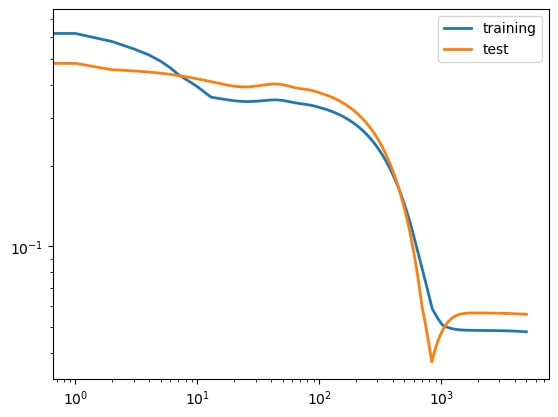

In [6]:
print(model.summary())
bc     = history.history['mean_absolute_error']
bc_val     = history.history['val_mean_absolute_error']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2, label='training')
plt.loglog(range(np.shape(bc_val)[0]),bc_val, linewidth=2, label='test')
plt.legend()
plt.show()

4/4 [==============================] - 0s 2ms/step


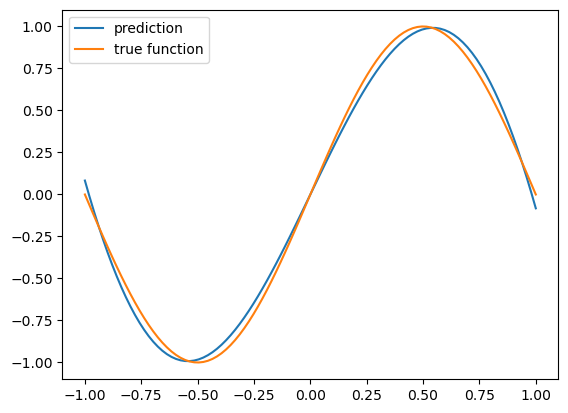

In [7]:
val = np.linspace(-1, 1, 100)
phi_val = phi(val)
y_pred = model.predict(phi_val)
plt.plot(val, y_pred, label='prediction')
plt.plot(val, func(val), label='true function')
plt.legend()

## 2D Helmotz

In [57]:
M = 300
Rm = 2
dim = 2
weights = np.zeros((M, dim))
biases = np.zeros((M, dim))

for i in range(M):
    for j in range(dim):
        weights[i, j] = np.random.uniform(low=-Rm, high=Rm)
        biases[i, j] = np.random.uniform(low=-0.0005, high=0.0005)

def phi(x):
    out = np.zeros((np.shape(x)[0],M, dim))
    for j in range(np.shape(x)[0]):
        for i in range(M):
            for k in range(dim):
                out[j][i][k] = tf.sin(weights[i][k]*x[j][k] + biases[i][k])
    return out

xx = np.zeros((4,2))

print(np.shape(phi(xx)))
print(np.shape(phi(xx).reshape(4, M*dim)))

(4, 300, 2)
(4, 600)


In [58]:
model2 = Sequential()
model2.add(Dense(1, input_dim=M*dim))

model2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', 
                metrics=[tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),'accuracy'])

In [59]:
x_train = np.linspace(0, 1, 20)
x_test = np.linspace(0, 1, 7)

train = np.zeros((400, dim))
test = np.zeros((49, dim))
k = 0
k_test = 0
for i in range(20):
    for j in range(20):
        train[k][0] = x_train[i]
        train[k][1] = x_train[j]
        if i < 7 and j < 7:
            test[k_test][0] = x_test[i]
            test[k_test][1] = x_test[j]
            k_test = k_test + 1
        k = k + 1

In [37]:
print(np.shape(train))
print(np.shape(phi(train)))

(400, 2)
(400, 100, 2)


In [60]:
phi_train = phi(train)
phi_test = phi(test)

phi_train = phi_train.reshape(np.shape(phi_train)[0], M*dim)
phi_test = phi_test.reshape(np.shape(phi_test)[0], M*dim)

def func(x):
    k0 = 2*np.pi*dim
    return tf.sin(k0 * x[:, 0:1]) * tf.sin(k0 * x[:, 1:2])

y_train = func(train)
y_test = func(test)

In [61]:
history2 = model2.fit(phi_train, y_train, validation_data = (phi_test,y_test), epochs=1500, batch_size=64)

Epoch 1/1500
7/7 [==============================] - 1s 35ms/step - loss: 0.3212 - mean_absolute_error: 0.4505 - accuracy: 0.0925 - val_loss: 0.2506 - val_mean_absolute_error: 0.3884 - val_accuracy: 0.2653
Epoch 2/1500
7/7 [==============================] - 0s 6ms/step - loss: 0.2572 - mean_absolute_error: 0.3984 - accuracy: 0.0975 - val_loss: 0.2174 - val_mean_absolute_error: 0.3537 - val_accuracy: 0.2653
Epoch 3/1500
7/7 [==============================] - 0s 6ms/step - loss: 0.2422 - mean_absolute_error: 0.3926 - accuracy: 0.0975 - val_loss: 0.1996 - val_mean_absolute_error: 0.3232 - val_accuracy: 0.2653
Epoch 4/1500
7/7 [==============================] - 0s 6ms/step - loss: 0.2360 - mean_absolute_error: 0.3718 - accuracy: 0.0975 - val_loss: 0.1935 - val_mean_absolute_error: 0.3033 - val_accuracy: 0.2653
Epoch 5/1500
7/7 [==============================] - 0s 6ms/step - loss: 0.2319 - mean_absolute_error: 0.3850 - accuracy: 0.0975 - val_loss: 0.1860 - val_mean_absolute_error: 0.2728 - 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1)                 601       
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________
None


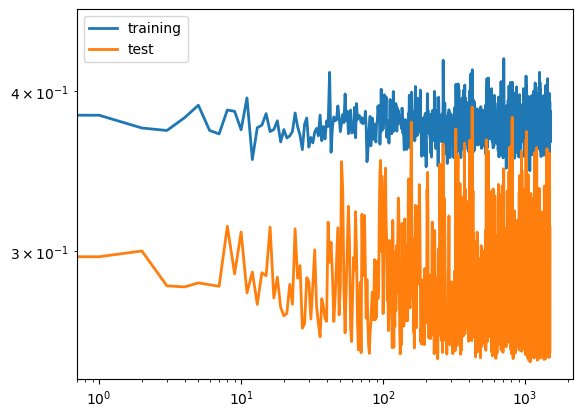

In [ ]:
print(model2.summary())
bc     = history2.history['mean_absolute_error']
bc_val     = history2.history['val_mean_absolute_error']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,label='training')
plt.loglog(range(np.shape(bc_val)[0]),bc_val, linewidth=2,label='test')
plt.legend()
plt.show()

In [65]:
x_val = np.linspace(0, 1, 10)
val = np.zeros((100,2))
k = 0
for i in range(10):
    for j in range(10):
        val[k][0] = x_val[i]
        val[k][1] = x_val[j]
        k = k + 1
phi_val = phi(val)
y_pred = model.predict(phi_val.reshape(np.shape(phi_val)[0], M*dim))
plt.plot(val, y_pred, label='prediction')
plt.plot(val, func(val), label='true function')
plt.legend()

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_7/dense_6/MatMul' defined at (most recent call last):
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Marco\AppData\Local\Temp\ipykernel_12220\4249827134.py", line 10, in <module>
      y_pred = model.predict(phi_val.reshape(np.shape(phi_val)[0], M*dim))
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Marco\anaconda3\envs\mesh\lib\site-packages\keras\layers\core\dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential_7/dense_6/MatMul'
Matrix size-incompatible: In[0]: [32,600], In[1]: [100,1]
	 [[{{node sequential_7/dense_6/MatMul}}]] [Op:__inference_predict_function_14074158]